In [2]:
import sys
import os


import numpy as np
import keras

from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import Bidirectional, TimeDistributed, GRU
from keras.layers import LSTM, Input, Reshape, Concatenate, Flatten,Convolution1D
from keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling1D, MaxPool2D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

import itertools
import pandas as pd

import spacy
import nltk
import re

from tqdm import tqdm
from os.path import expanduser, exists

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

%matplotlib inline
sns.set(style='whitegrid', palette='muted')
# pd.set_option('display.max_colwidth', 300) #widen pandas rows display

# Emedding

In [20]:
def get_splits(X, y, max_words = 20000, MAX_SEQUENCE_LENGTH = 100, EMBEDDING_DIM = 300):
    tokenizer = Tokenizer(num_words=max_words,lower=True, split=' ', 
                          filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                          char_level=False, oov_token=u'<UNK>')

    tokenizer.fit_on_texts(X)

    X = tokenizer.texts_to_sequences(X)
    Y = pd.get_dummies(y).values
    # print(X[0])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,  padding="post", truncating="post")
    # print(X[10])

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                        random_state = 42)

    # print(y_train[100])

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)
    
    return x_train, x_test, y_train, y_test, word_index

In [79]:
max_words = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100 

from data_util import get_fake_or_real_news, get_politifact, get_fact_fake

# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_fake_or_real_news()
# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_politifact()
# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_fact_fake()

def to_label(cat):
    return categories[cat]


##### SNOPES
data_train = pd.read_csv('data/snopes_processed.tsv', sep='\t')
categories = {True:u'true', False: u'false'}
data_train['label'] = data_train['label'].apply(to_label)
X = data_train['claim'].values.astype(str)
y = data_train['label'].values
labels = data_train['label'].unique()
print(labels)
num_classes = len(labels)
x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
###################

##### FakeNewsNet #####################################
# def add_text(row):
#     return row['title_tokens'] + ' ' + row['text_tokens'] 
    
# categories = {'FakeNewsContent':'False', 'RealNewsContent':'True'}
# data_train = pd.read_csv('data/fakeNewsNet.csv', sep='\t')
# data_train.dropna(how='any', inplace=True) 
# print(data_train['collected_by'].unique())
# print(data_train['collected_by'].value_counts())
# print(data_train['label'].unique())
# print(data_train.isnull().values.any())
# data_train['label'] = data_train['label'].apply(to_label)
# data_train['document'] = data_train.apply(add_text, axis=1)
# X =  data_train['document'].values
# y = data_train['label'].values
# labels = data_train['label'].unique()
# print(data_train['label'].value_counts())
# labels = data_train['label'].unique()
# print(labels)
# num_classes = len(labels)
# x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
#################################################

##### Unreliable News Data ##################################
# data_train = pd.read_csv('data/newsfiles/fulltrain.csv', names=['label', 'text'])
# categories = {1:"Satire",2:"Hoax",
#               3:"Propaganda",4:"Trusted"}

# data_train['label'] = data_train['label'].apply(to_label)
# X =  data_train['text'].values
# y = data_train['label'].values
# labels = data_train['label'].unique()
# num_classes = len(labels)
# print(data_train['label'].value_counts())
# x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
############################

vocabulary_inv = dict((v, k) for k, v in word_index.items())
print('Found %s unique tokens.' % len(vocabulary_inv))
vocabulary_inv[0] = "<PAD/>"

# x_train[:10]

['false' 'true']
Found 17413 unique tokens.
x_train shape: (4804, 100)
x_test shape: (1202, 100)
y_train shape: (4804, 2)
y_test shape: (1202, 2)
Found 17413 unique tokens.


In [80]:

# Set parameters:
# ngram_range = 2 will add bi-grams features
max_words = 20000
MAX_SEQUENCE_LENGTH = 400
EMBEDDING_DIM = 100 

ngram_range = 2
max_features = max_words
maxlen = MAX_SEQUENCE_LENGTH
batch_size = 32
embedding_dims = EMBEDDING_DIM
epochs = 5

def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in tqdm(sequences):
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
#                     new_list.append(token_indice[ngram])
                      np.append(new_list, token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences



print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in tqdm(x_train):
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


def fasttext():
    print('Build model...')
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))

    # we add a GlobalAveragePooling1D, which will average the embeddings
    # of all words in the document
    model.add(GlobalAveragePooling1D())

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model
    
# model = fasttext()
# print(model.summary())
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(x_test, y_test))

  0%|          | 0/4804 [00:00<?, ?it/s]

Loading data...
4804 train sequences
1202 test sequences
Average train sequence length: 100
Average test sequence length: 100
Adding 2-gram features


100%|██████████| 1202/1202 [00:00<00:00, 2051.94it/s]


Average train sequence length: 100
Average test sequence length: 100
Pad sequences (samples x time)
x_train shape: (4804, 400)
x_test shape: (1202, 400)


In [81]:
# from keras.datasets import imdb
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# print(x_train[1])

In [82]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(model, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    y_pred = model.predict(x_test)

    class_labels = np.argmax(y_test, axis=1) 
    
    print(metrics.classification_report(class_labels, y_pred.argmax(axis=1), 
                                        target_names=labels, digits=3))
    
    #Plot ROC curve
#     plot_ROC(class_labels, y_pred)
    
    cm = confusion_matrix(class_labels, 
                          y_pred.argmax(axis=1))
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_ROC(class_labels, y_pred):
        
    print("Accuracy = {0} \t AUC = {1}".format(accuracy_score(class_labels, y_pred.argmax(axis=1)),
                                           roc_auc_score(class_labels, y_pred[:, 1])))

    fpr, tpr, _ = roc_curve(class_labels, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
#     print(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))



In [ ]:
embeddings_index = {}
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_FILE = 'glove.840B.300d.txt'

print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

In [83]:
def get_embedding_layer():
    count = 0
    embedding_matrix = np.random.uniform(-1,0,(len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector[:EMBEDDING_DIM]
            count += 1
            
    print('Word embeddings: %d' % len(embeddings_index))
    print('found number of tokens in embedding space: ', count)

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    return embedding_layer


In [84]:
def GRU_2():
    model = Sequential()
    model.add(get_embedding_layer())
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss = 'binary_crossentropy', 
                  optimizer='Adagrad', metrics = ['accuracy'])
    return model
    


In [85]:
# https://www.kaggle.com/eashish/bidirectional-gru-with-convolution/code

def bidirectional_conv_GRU():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
    x =  get_embedding_layer()(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
    x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool]) 
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    preds = Dense(num_classes, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    return model



In [86]:
def bidirectional_GRU():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = get_embedding_layer()(sequence_input)
    l_lstm = Bidirectional(GRU(100))(embedded_sequences)
    preds = Dense(num_classes, activation='softmax')(l_lstm)
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model


In [87]:
def simple_LSTM():
    model = Sequential()
    model.add(get_embedding_layer())
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))

    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=adam, metrics = ['acc'])
    return model



Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 400, 100)          7224000   
_________________________________________________________________
global_average_pooling1d_16  (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 202       
Total params: 7,224,202
Trainable params: 7,224,202
Non-trainable params: 0
_________________________________________________________________
None
Train...
Train on 4804 samples, validate on 1202 samples
Epoch 1/50
4804/4804 [==============================] - 1s 216us/step - loss: 0.6294 - acc: 0.7648 - val_loss: 0.5622 - val_acc: 0.7995

 ROC-AUC - epoch: 1 - score: 0.550917

Epoch 00001: val_acc improved from -inf to 0.79950, saving model to data/weights_base.best.hdf5
Epoch 2/50
4804/4804 [=========================

4804/4804 [==============================] - 0s 95us/step - loss: 0.4512 - acc: 0.8075 - val_loss: 0.4937 - val_acc: 0.7995

 ROC-AUC - epoch: 35 - score: 0.635827

Epoch 00035: val_acc did not improve
Epoch 36/50
4804/4804 [==============================] - 0s 99us/step - loss: 0.4475 - acc: 0.8075 - val_loss: 0.4914 - val_acc: 0.7995

 ROC-AUC - epoch: 36 - score: 0.636198

Epoch 00036: val_acc did not improve
Epoch 37/50
4804/4804 [==============================] - 0s 95us/step - loss: 0.4433 - acc: 0.8075 - val_loss: 0.4906 - val_acc: 0.7995

 ROC-AUC - epoch: 37 - score: 0.635982

Epoch 00037: val_acc did not improve
Epoch 38/50
4804/4804 [==============================] - 0s 99us/step - loss: 0.4402 - acc: 0.8076 - val_loss: 0.4906 - val_acc: 0.7995

 ROC-AUC - epoch: 38 - score: 0.635483

Epoch 00038: val_acc did not improve
Epoch 39/50
4804/4804 [==============================] - 0s 96us/step - loss: 0.4355 - acc: 0.8075 - val_loss: 0.4892 - val_acc: 0.7995

 ROC-AUC - epoch: 3

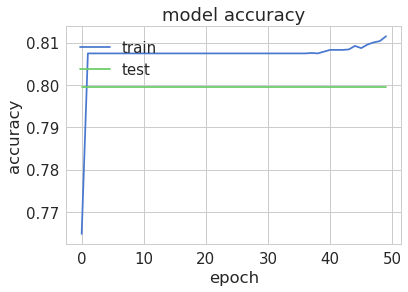

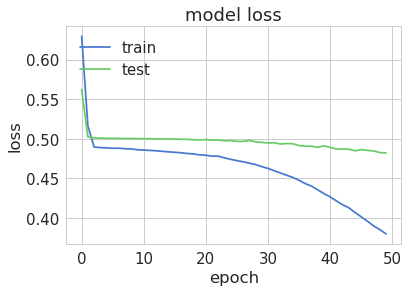

             precision    recall  f1-score   support

      false      0.800     1.000     0.889       961
       true      0.000     0.000     0.000       241

avg / total      0.639     0.800     0.710      1202

Confusion matrix, without normalization
[[961   0]
 [241   0]]


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


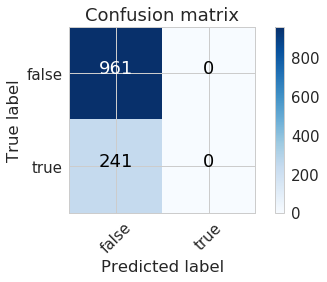

In [88]:
# RUN THE MODEL
batch_size = 100
epochs = 50

##########
filepath="data/weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=50)
ra_val = RocAucEvaluation(validation_data=(x_test, y_test), interval = 1)
callbacks_list = [ra_val,checkpoint, early]
##########

# model = bidirectional_conv_GRU()
# model = bidirectional_GRU()
# model = simple_LSTM()
# model = GRU_2()
model = fasttext()

print(model.summary())

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

print('Train...')
network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=epochs,
                         verbose=1, validation_data=(x_test, y_test),
                         callbacks = callbacks_list,
                         validation_split=0.2)


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import itertools
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

def test(model, data):
    x_test, y_test = data
    y_pred = model.predict(x_test)
    print('-' * 50)

    class_labels = np.argmax(y_test, axis=1) 
#     print(class_labels[:10])
#     print(y_pred.argmax(axis=1))
    y_pred = y_pred.argmax(axis=1)
    
#     print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])
#     print(y_pred)
#     y_pred = model.predict_classes(x_test)
#     print(y_pred)
    
#     print(np.argmax(y_pred, 1))

#     print(classification_report(np.argmax(y_test, axis=1), 
#                                 y_pred, target_names=target_names))
    
#     result = model.evaluate(x_test, y_test, batch_size=batch_size)
#     print( confusion_matrix(y_test, y_pred, 1) )
    f1 = f1_score(class_labels, y_pred.round(), average='macro')  
    percision = precision_score(class_labels, y_pred.round(), average='macro')  
    recall = recall_score(class_labels, y_pred.round(), average='macro')

    return f1, percision, recall

In [ ]:
%%time

Y = y
epochs = 20
batch_size=128

print(X.shape)
print(Y.shape)

# evaluate using 10-fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

score = []

for train_index, test_index in tqdm(skf.split(X, y)):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    
    ##########
    filepath="data/weights_base.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
    ra_val = RocAucEvaluation(validation_data=(x_test, y_test), interval = 1)
    callbacks_list = [ra_val,checkpoint, early]
    ##########

    # model = bidirectional_conv_GRU()
    # model = bidirectional_GRU()
    # model = simple_LSTM()
    model = GRU_2() 

    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, verbose=0,
          validation_data=(x_test, y_test))

#         result = model.evaluate(x_test, y_test, batch_size=batch_size)
    f1, percision, recall = test(model=model, data=(x_test, y_test))
    score.append({'f1': f1, 'percision' : percision, 'recall' : recall})
    print('F1: ', f1, ' percision: ', percision, ' recall: ', recall)
    
#     print(score_temp)
#     score.append([name, score_temp])
#     print('average percision over kfolds:', np.average([x['percision'] for x in score_temp]))

print('average f1 over kfolds:', np.average([x['f1'] for x in score]))
print('average percision over kfolds:', np.average([x['percision'] for x in score]))
print('average recall over kfolds:', np.average([x['recall'] for x in score]))

# print(score)
df_result = pd.DataFrame(score)
df_result.head()

df_result.to_csv('data/NNResults.csv')

In [ ]:

df_result.plot()
df_result.describe()